In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM,GRU
from tensorflow import keras,ones_like,zeros_like
from tensorflow.keras import layers
import tensorflow as tf


Import data

In [2]:
data = pd.read_csv("D:\\học đại học\\20222\\machine learning\\data.csv")

In [3]:
data=data[::-1]
data = data.reset_index(drop=True)

time=data['Date']
data=data.drop(['Date','BTC_change'], axis=1)

target="BTC_close"

In [4]:
data.head()

,BTC_close,BTC_open,BTC_high,BTC_low,difficulty,addresses_active_count,sum_lock_weight,mean_lock_size_ytes,total_fees_usd,mean_hash_rate,...,ETH,LTC,XRP,DOGE,COPPER,GOLD,SILVER,SPX,JP225,DJI
0,415.8,412.8,417.5,410.3,158427203767,445273,426654988,688153.206452,17312.723752,1.220696e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,419.1,415.8,422.4,415.1,158427203767,434658,398582424,622785.037500,17101.930760,1.260073e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,410.4,419.1,420.7,407.0,158427203767,374730,331208848,575015.361111,13984.439830,1.134066e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,412.4,410.4,415.9,409.6,158427203767,421585,334817852,629356.864662,14606.780891,1.047436e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,414.3,412.4,416.1,411.2,158427203767,451902,437739524,719966.322368,16892.976657,1.197070e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


split data to 3 sets train, valid,test sets with ratio are 70/15/15

In [5]:
train_data= data.copy().iloc[:int(0.7*len(data)),:]
train_np= train_data.to_numpy()
val_data=data.copy().iloc[int(0.7*len(data)):int(0.85*len(data)),:]
val_np=val_data.to_numpy()
test_data=data.copy().iloc[int(0.85*len(data)):,:]
test_np=test_data.to_numpy()

In [6]:
train_time=time[:int(0.7*len(data))]
val_time=time[int(0.7*len(data)):int(0.85*len(data))]
test_time=time[int(0.85*len(data)):]

In [7]:
train_np = np.asarray(train_np).astype('float32')
val_np = np.asarray(val_np).astype('float32')
test_np = np.asarray(test_np).astype('float32')

Denote time step is 40 (this means we are using 40 previous days to predict the next day)

In [8]:
time_step=40
train_time_line=[]
val_time_line=[]
test_time_line=[]

In [9]:
def scale_sequence_data(df,timesteps ,close_col_idx):
    x = []
    y = []
    timeLine=[]
    target=df[:,close_col_idx]
    for i in range(len(df)-timesteps):  
        scaler=MinMaxScaler()      
        scaler.fit(df[i:i+timesteps,:])
        timeLine.append((scaler.data_min_[close_col_idx],scaler.data_max_[close_col_idx]))
        x.append(scaler.transform(df[i:i+timesteps,:]))
        value=target[i:i+timesteps][::1]
        max1,min1=max(target[i:i+timesteps]),min(target[i:i+timesteps])
        value1 = np.concatenate([value, [max1 * 1.2, min1 * 1.2]],axis=0)
        # print(value1.shape,value.shape)
        scaler.fit(value1.reshape(-1,1))
        # print(target[i+timesteps].reshape(-1,1).shape)
        value1=scaler.transform(target[i+timesteps].reshape(-1,1))
        y.append(value1)
    return np.array(x),np.array(y),timeLine


In [10]:
train_x, train_y,train_time_line = scale_sequence_data(train_np, time_step,data.columns.get_loc('BTC_close'))
val_x,val_y,val_time_line =scale_sequence_data(val_np,time_step ,data.columns.get_loc('BTC_close'))
test_x, test_y,test_time_line = scale_sequence_data(test_np, time_step,data.columns.get_loc('BTC_close'))
# test_y=test_y.reshape(-1)
# train_y,val_y=train_y.reshape(-1),val_y.reshape(-1)

**1.Generator**

In [11]:
class Generator(Model):
    def __init__(self,):
        super().__init__()

        self.LSTM1 = GRU(128, return_sequences=True, recurrent_dropout=0.3)
        self.LSTM2 = GRU(128, return_sequences=True, recurrent_dropout=0.3)
        self.LSTM3 = GRU(64, return_sequences=False, recurrent_dropout=0.3)
        self.dense1 = Dense(16, activation='tanh')
        self.dense2 = Dense(1, activation='sigmoid')        
    def call(self, inputs):
        x1 = self.LSTM1(inputs)
        x2 = self.LSTM2(x1)
        x3 = self.LSTM3(x2)
        x4 = self.dense1(x3)
        x5=self.dense2(x4)
        return x5
        
generator = Generator()

**2.Discriminator**

In [12]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.Dense1 = Dense(256, activation=tf.keras.layers.LeakyReLU(0.01))
        self.Dense2 = Dense(128, activation=tf.keras.layers.LeakyReLU(0.01))
        self.Dense3 = Dense(64, activation=tf.keras.layers.LeakyReLU(0.01))
        self.Dense4 = Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x1 = self.Dense1(inputs) 
        x2 = self.Dense2(x1)
        x3 = self.Dense3(x2)
        return self.Dense4(x3)
        
discriminator = Discriminator()


loss function

In [13]:
mse = keras.losses.MeanSquaredError()
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [14]:
adam = keras.optimizers.legacy.Adam(
    learning_rate=0.0002
)
generator_optimizer = adam
discriminator_optimizer = adam

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(ones_like(real_output), real_output)
    fake_loss = cross_entropy(zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return 3*mse(train_y.reshape((-1,1)),generator(train_x)) + cross_entropy(ones_like(fake_output), fake_output)

In [16]:
def train_step(real_x,real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data=generator(real_x,training=True) # [price1,price2,...]
        real_output = discriminator(real_y, training=True)
        fake_output = discriminator(generated_data, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    print("Generator loss %s | Discriminator loss %s" %(float(gen_loss), float(disc_loss)))
    print("Val loss evaluation", generator.evaluate(val_x,val_y))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return real_y, generated_data, disc_loss,gen_loss


**Train**

In [17]:
train_x[:512].shape

(512, 40, 22)

In [18]:
generator.compile(loss="MeanSquaredError")
epochs=20
batch_size=256
list_d_loss=[]
list_g_loss=[]
for i in range(epochs):
    for j in range(0,train_x.shape[0]-batch_size-1,batch_size):
        print("*i =", i, "and j =", j, ":")
        real_x=train_x[j:batch_size+j]
        real_y=train_y[j:batch_size+j]
        real_y, generated_data,d_loss,g_loss=train_step(real_x,real_y)
        list_d_loss.append(d_loss)
        list_g_loss.append(g_loss)
        

*i = 0 and j = 0 :


Generator loss 0.9623889923095703 | Discriminator loss 1.380272388458252
12/12 [==============================] - 2s 28ms/step - loss: 0.1399
Val loss evaluation 0.1399346888065338
*i = 0 and j = 256 :
Generator loss 0.9217015504837036 | Discriminator loss 1.386149287223816
12/12 [==============================] - 0s 21ms/step - loss: 0.1171
Val loss evaluation 0.11706648021936417
*i = 0 and j = 512 :
Generator loss 0.8962604403495789 | Discriminator loss 1.383925437927246
12/12 [==============================] - 0s 23ms/step - loss: 0.1007
Val loss evaluation 0.10072514414787292
*i = 0 and j = 768 :
Generator loss 0.8802547454833984 | Discriminator loss 1.374387502670288
12/12 [==============================] - 0s 30ms/step - loss: 0.0875
Val loss evaluation 0.08754847198724747
*i = 0 and j = 1024 :
Generator loss 0.8706878423690796 | Discriminator loss 1.3849176168441772
12/12 [==============================] - 1s 40ms/step - loss: 0.0771
Val loss evaluation 0.07712680101394653
*i = 

Traceback (most recent call last):
  File "c:\Users\long0\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\long0\AppData\Local\Temp\ipykernel_27896\3642585739.py", line 11, in <module>
    real_y, generated_data,d_loss,g_loss=train_step(real_x,real_y)
  File "C:\Users\long0\AppData\Local\Temp\ipykernel_27896\3137310283.py", line 8, in train_step
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  File "c:\Users\long0\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\eager\backprop.py", line 1063, in gradient
    flat_grad = imperative_grad.imperative_grad(
  File "c:\Users\long0\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\eager\imperative_grad.py", line 67, in imperative_grad
    return pywrap_tfe.TFE_Py_TapeGradient(
  File "c:\Users\long0\AppData\Local\P

In [19]:
generator.evaluate(test_x,test_y)

12/12 [==============================] - 0s 29ms/step - loss: 0.0183


0.01834917813539505

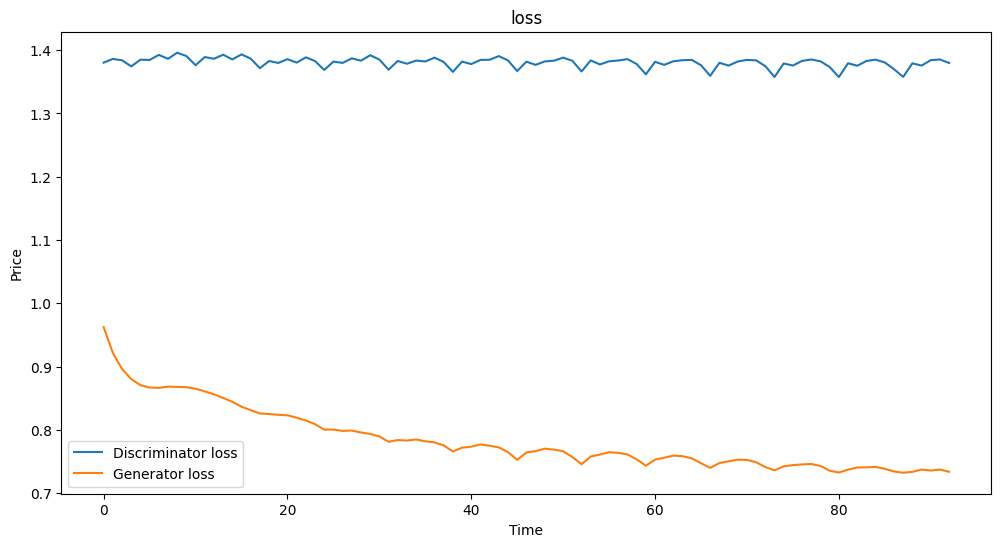

In [20]:
plt.figure(figsize=(12,6))
plt.plot(list_d_loss, label='Discriminator loss')
plt.plot(list_g_loss, label='Generator loss')

plt.title('loss')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [21]:
prediction = generator.predict(test_x)
train_pred=generator.predict(train_x)

57/57 [==============================] - 2s 33ms/step


In [30]:
test_y,train_y,val_y=test_y.reshape(-1,1),train_y.reshape(-1,1),val_y.reshape(-1,1)

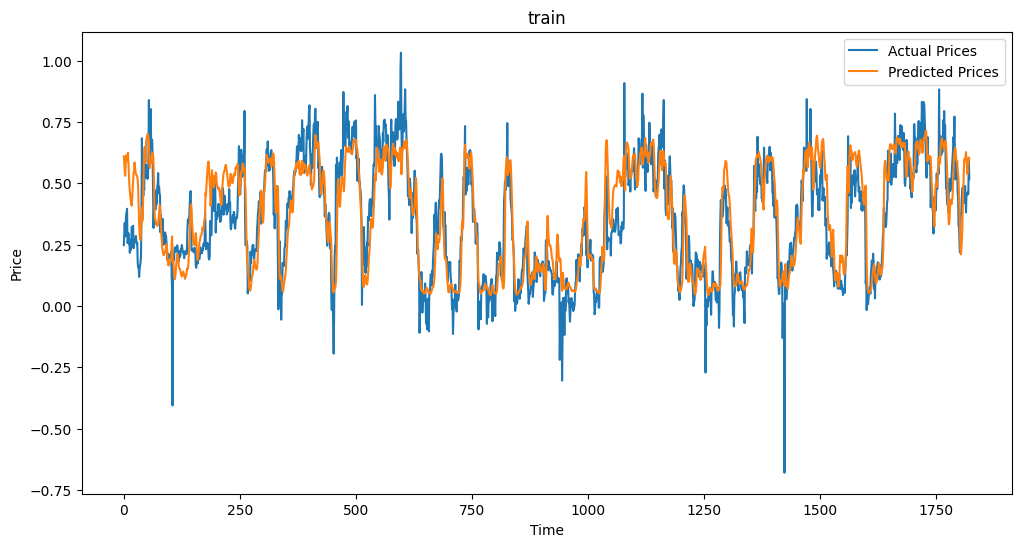

In [31]:
plt.figure(figsize=(12,6))
plt.plot(train_y, label='Actual Prices')
plt.plot(train_pred, label='Predicted Prices')

plt.title('train')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

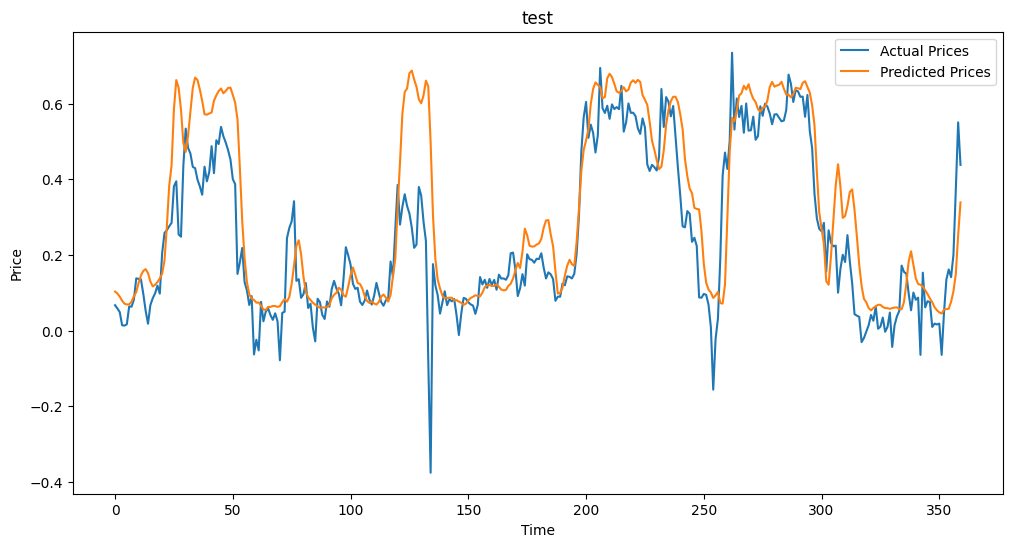

In [32]:
plt.figure(figsize=(12,6))
plt.plot(test_y, label='Actual Prices')
plt.plot(prediction, label='Predicted Prices')

plt.title('test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [33]:
def inverseTransform(value, timeline):
    result = []
    for i in range(len(timeline)):
        min_val = timeline[i][0]
        max_val = timeline[i][1]
        original_value = (value[i] * (max_val - min_val)) + min_val
        result.append(original_value)
    return np.array(result)


In [34]:
pred_after_inverse=inverseTransform(prediction,test_time_line)
true_after_inverse=inverseTransform(test_y,test_time_line)
inverse_train_pred=inverseTransform(train_pred,train_time_line)
inverse_train_true=inverseTransform(train_y,train_time_line)

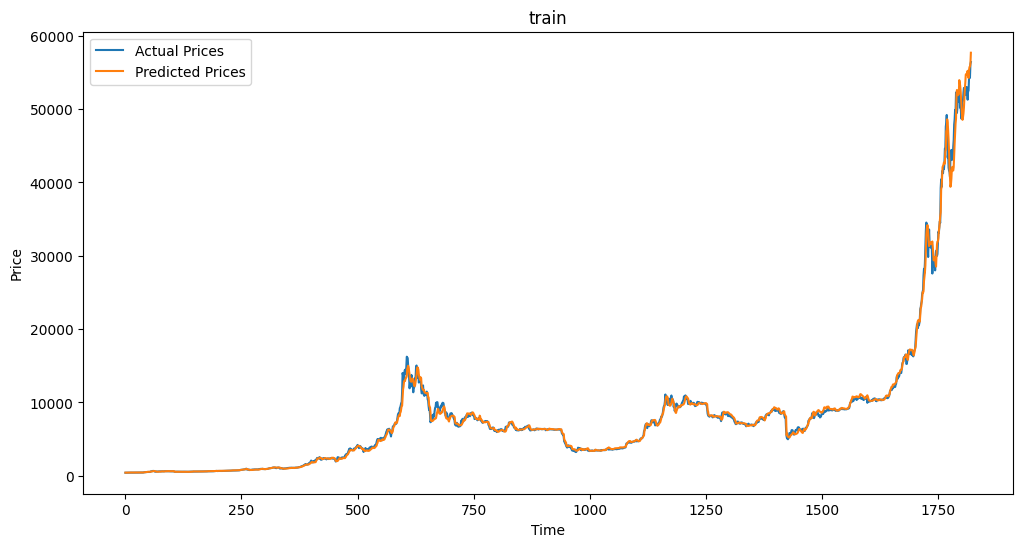

In [35]:
plt.figure(figsize=(12,6))
plt.plot(inverse_train_true, label='Actual Prices')
plt.plot(inverse_train_pred, label='Predicted Prices')

plt.title('train')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

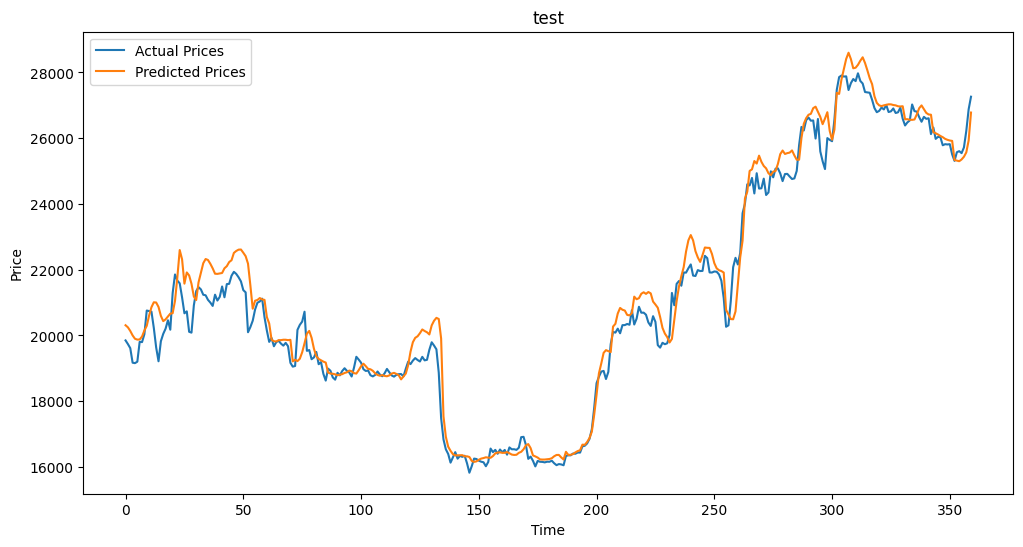

In [36]:
plt.figure(figsize=(12,6))
plt.plot(true_after_inverse, label='Actual Prices')
plt.plot(pred_after_inverse, label='Predicted Prices')

plt.title('test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

true_train = inverse_train_true
prediction_train = inverse_train_pred
prediction_test = pred_after_inverse
true_test = true_after_inverse
def print_evaluation_results(true_values, predicted_values, dataset_name):
    print("Test ACCuracy for", dataset_name)
    print("------------------------------------------------------")
    # RMSE
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    print("Root Mean Square Error (RMSE): {:.4f}".format(rmse))
    
    # MAPE
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    print("Mean Absolute Percentage Error (MAPE): {:.4f}".format(mape))
    #r2 score
    print("R2 score: ", r2_score(true_values,predicted_values))

# Print evaluation results for the train set
print_evaluation_results(true_train, prediction_train, "train set")

# Print evaluation results for the test set
print_evaluation_results(true_test, prediction_test, "test set")




Test ACCuracy for train set
------------------------------------------------------
Root Mean Square Error (RMSE): 591.2842
Mean Absolute Percentage Error (MAPE): 0.0312
R2 score:  0.9961189861837859
Test ACCuracy for test set
------------------------------------------------------
Root Mean Square Error (RMSE): 568.7914
Mean Absolute Percentage Error (MAPE): 0.0197
R2 score:  0.9738518591050999
